# Mini-Projet : Segmentation d'images TEP par classification spectrale

L'objectif de ce TP est de segmenter des images de Tomographie par Emission de Positons (TEP)  via des méthodes de classification non supervisée et, en particulier, une méthode de classification spectrale. 

## Principe de l'imagerie TEP 

La Tomographie par Emission de Positons (ou TEP) est une technique d'imagerie médicale fonctionnelle quantitative permettant de visualiser les activités du métabolisme. Les données TEP forment une sèquence *3D + t* qui traduit l'évolution de la radioactivité dans le temps du volume correspondant au champ de vue de l'appareil de mesure.


<img src="./PrincipePET.png" width="600" height="300">



Nous nous intéressons, dans ce TP, à la segmentation d'une coupe transverse et sagittale du cerveau, réprésentée respectivement à gauche et à droite sur la figure ci-dessous. Le nombre de classes à retrouver correspond aux différentes couleurs représentées sur la figure. Ici, l'information géométrique (position de chaque pixel dans l'image) n'est pas prise en compte.

<img src="./zubal_fig3.png" width="600" height="300">


Ce mini-projet se décompose en 5 parties:
- **Partie I :** implémentation de la classification spectrale avec exemple jouet 
- **Partie II :** application de la classification spectrale sur les protils temporels TACs 
- **Partie III :** classification par Kmeans puis par réduction de dimension ACP+Kmeans
- **Partie IV :** évaluation des résultats
- **Partie V :** votre analyse



In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import mpi4py as MPI

## Partie I : Classification spectrale

Parmi les méthodes de partitionnement non supervisé, les méthodes à noyaux reposent sur le même principe : elles utilisent des relations d'adjacence (d'affinité) entre tous les couples de points sans a priori sur les formes des classes. Nous nous concentrons sur l'algorithme de classification spectrale décrit ci-dessous, très simple à implémenter. La mesure d'affinité utilisée est l'affinité gaussienne qui dépend d'un paramètre noté $\sigma$.


On dispose d'un ensemble  de données $S=\{x_i\}_{i=1,..,n}\in \mathbb{R}^p$ composé de $n$ points de dimension $p$ et d'un nombre de classes, noté $k$, à obtenir. La méthode de classification spectrale  consiste à extraire les vecteurs propres associés aux plus grandes valeurs propres d'une matrice d'affinité normalisée. Ces vecteurs propres constituent ensuite un espace de dimension réduite dans lequel les données transformées seront linéairement séparables.  

<img src="AlgoSC.png" width="600" height="300">
<img src="SCexple.png" width="600" height="300">


### Travail demandé

- Ecrire la fonction **classification_spectrale** implantant l'algorithme 1. Cette fonction en entrée les données Input de l'algorithme.
- Tester la fonction sur le jeu de données *ToyExample.mat* et tester différentes valeurs de paramètres $\sigma$. Les résultats sont-ils similaires ?


### Fonctions python utiles
- exp (numpy)
- norm (linalg)
- inv (linalg)
- eig (linalg)
- KMeans (sklearn)

In [3]:

def classification_spectrale(Data,k,sigma):
    Data=np.asarray(Data)
    k=int(k)

    size = Data.shape[0]
    dim = (size, size)

    # construction de la matrice affinité
    Affinite = np.zeros(dim)
    for i in range(size):
        for j in range(size):
            if i == j: #not using the conditional operator because th syntax is fucking unreadable garbage
                Affinite[i, j] = 0
            else:
                Affinite[i, j] =  np.exp(- np.square(np.linalg.norm(Data[i] - Data[j])) / (2 * sigma * sigma))

    #print(Affinite)

    # Normalisation de la matrice affinité
    D = np.zeros(dim)
    for i in range(size):
        D[i, i] = np.sum(Affinite[i])


    L = np.matmul(np.linalg.inv(D), Affinite)

    # Calcul des vecteurs propres de L
    (valp, vecp) = np.linalg.eig(L)


    #Extraction des k + grands vecteurs propres
    X = vecp.T[np.argsort(valp)][::-1][:k]

    # Normalisation des lignes de X
    Y = np.zeros((size, k))
    for i in range(size):
        for j in range(k):
            Y[i, j] = X[j, i] / np.sqrt(np.sum(X[:,i]**2))
    
    #print(Y)

    #Kmeans sur l'espace spectral
    #PartitionSC=np.zeros((size, 1))
    
    kmeans = KMeans(k, init='k-means++', random_state=0).fit(Y)

    PartitionSC = kmeans.labels_

    return PartitionSC

### Application : toy example

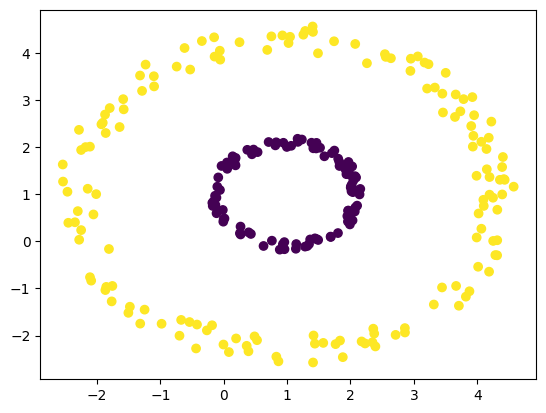

In [4]:
matJouet = scipy.io.loadmat('ToyExample.mat')

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)

# Visualisation du jeu de données 
#plt.plot(ExpleJouet[:,0],ExpleJouet[:,1],'.')


# Classification du jeu de données
k = 2

Data = ExpleJouet

Repartition = classification_spectrale(Data, k, 0.1)

# Visualisation des classes 
plt.scatter(Data[:,0], Data[:,1],c=Repartition)
plt.show()


# Partie II : application de la classification spectrale sur les protils temporels TACs  

La segmentation des images TEP repose donc sur une classification de profils temporels très bruités sans disposer de connaissance a priori.  Ces profils temporels s'appellent des courbes Temps-Activité (notées TAC pour *Time Activity Curves*). Comme ils traduisent l'évolution de la radioactivité, elles comportent principalement 2 phases : une phase de croissance  suivie d'une phase de décroissance. Suivant les tissus, les profils temporels vont présenter  différentes amplitudes et des phases de croissance et de décroissance de durées plus ou moins longues. 

La simulation numérique est couramment utilisée dans le domaine du traitement d'image. Elle
constitue une aide précieuse pour le développement et l'évaluation de méthodes car elle permet de
disposer d'une vérité terrain à laquelle on va comparer les résultats obtenus. Un exemple de simulation de TACs est représenté sur la figure suivante

Dans l'imagerie médicale, ces simulations sont généralement effectuées selon la méthode Monte-Carlo, particulièrement adaptées à la physique nucléaire à
cause de la nature stochastique des processus d'émission, de transport et de détection.

<img src="TAC_simu_reel.png" width="800" height="400">


On dispose de données temporelles simulées (séquences de 20 instants) d'une coupe transverse et d'une coupe sagittale de taille $64\times 54$ (représentées sur la figure ci-dessus) que l'on souhaite segmenter sans prendre en compte l'information géométrique. On dispose aussi de la vérité terrain c'est-à-dire de la segmentation de ces coupes avant simulation. Ces matrices sont stockées respectivement dans les fichiers *DataTAC_S.mat* et *DataTAC_T.mat*.



Nombre de TAC de la coupe Sagittale : (3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)


Text(0.5, 1.0, 'TAC de Coupe Transverse')

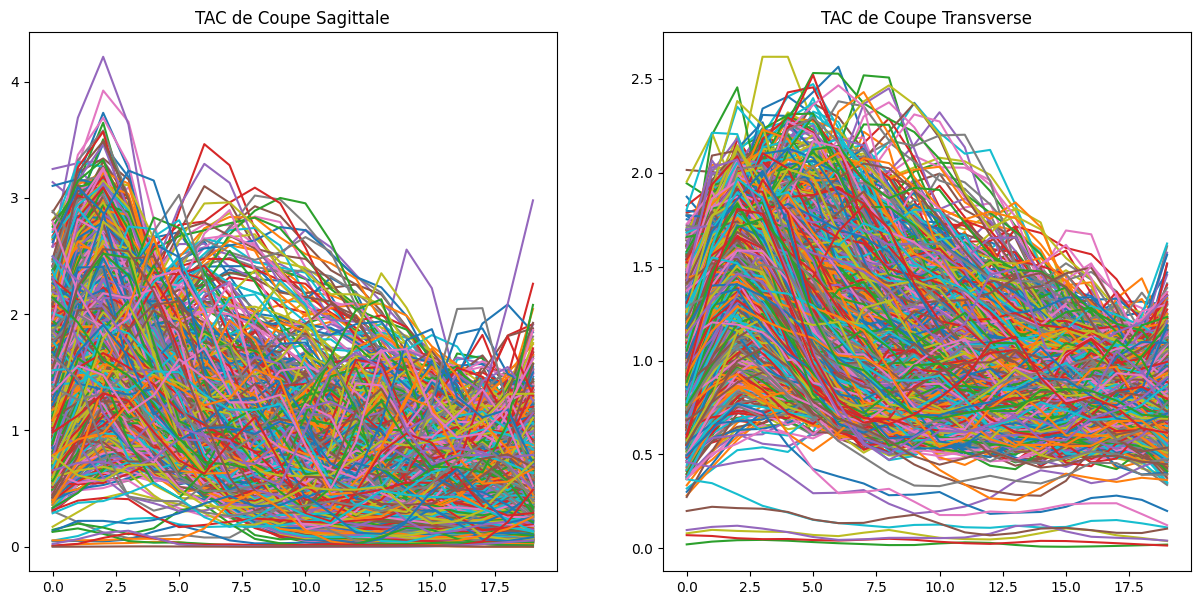

In [5]:
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

print('Nombre de TAC de la coupe Sagittale :', data_T.shape)

# Affichage des TAC des deux coupes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(data_S.T)
axs[0].set_title('TAC de Coupe Sagittale')
axs[1].plot(data_T.T)
axs[1].set_title('TAC de Coupe Transverse')


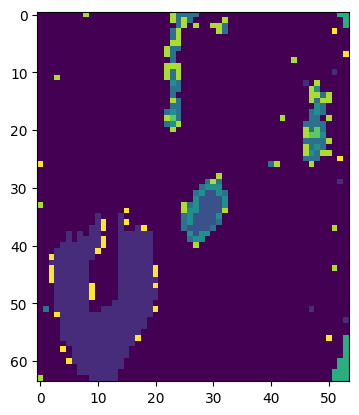

In [21]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 9 classes
PartitionSC_S=classification_spectrale(data_S, 9, 0.07)

# Redimensionnement de la partition de la coupe saggitale en (54,64)
ImSagittaleSC=np.reshape(PartitionSC_S,((54,64)))
plt.imshow(ImSagittaleSC.T)

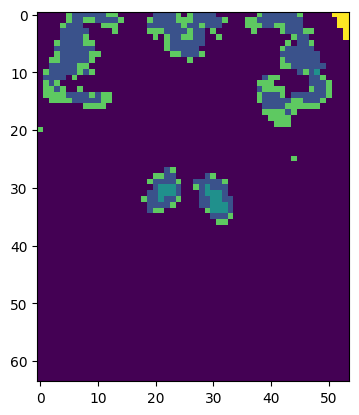

In [7]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 5 classes

PartitionSC_T=classification_spectrale(data_T, 5, 0.2)

# Redimensionnement de la partition de la coupe saggitale
ImTransverseSC=np.reshape(PartitionSC_T,(54,64))

plt.imshow(ImTransverseSC.T)


# Partie III : comparaison avec  kmeans (+ ACP)
  
- Réaliser une classification avec le kmeans de sklearn
- Tester aussi une réduction de dimension par ACP comme étape de prétraitement qui conserverait 95% de l'information

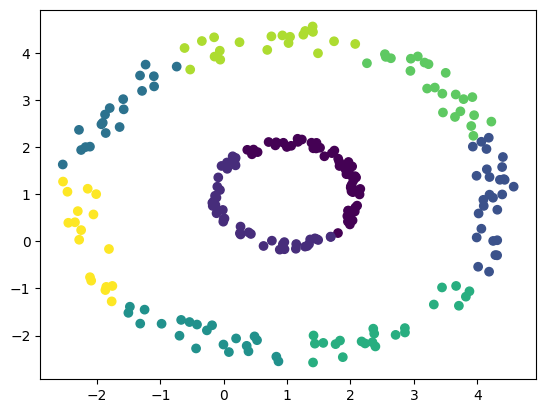

In [9]:
# Tester Kmeans avec l'exemple jouet et afficher le résultat 
# A COMPLETER

def showKmeans(data, k):
  kmeans = KMeans(k, init='k-means++', random_state=0).fit(data)
  plt.scatter(data[:,0], data[:,1],c=kmeans.labels_)
  plt.show()

showKmeans(ExpleJouet, 9)



In [10]:
# PAS BESOIN DE FAIRE AVEC ACP vu qu'on a que 2 composants on peut garder 95% de l'info qu'en gardant tout.

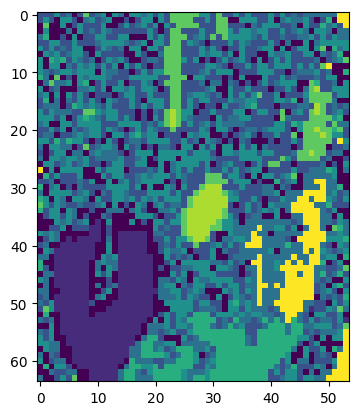

In [11]:
# Tester sur les TACS

def KMEANS(data, k):
  kmeans = KMeans(k, init='k-means++', random_state=0).fit(data)
  return kmeans.labels_

  
kmeansSansACP_S = KMEANS(data_S, 9)

imgKmeansSansACP_S = np.reshape(kmeansSansACP_S, (54, 64)).T

plt.imshow(imgKmeansSansACP_S)




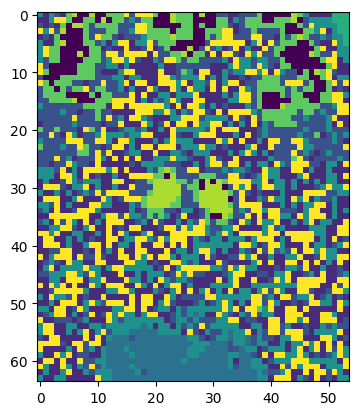

In [12]:
kmeansSansACP_T = KMEANS(data_T, 9)

imgKmeansSansACP_T = np.reshape(kmeansSansACP_T, (54, 64)).T

plt.imshow(imgKmeansSansACP_T)

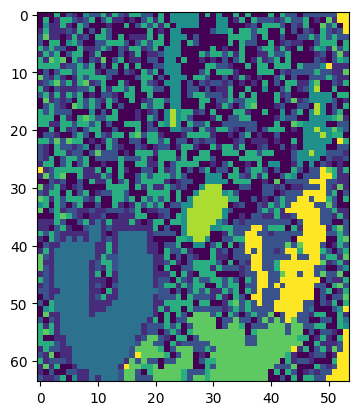

In [13]:
# AVEC ACP


def transformACP(data):
  acp = PCA().fit(data)
  variance_ratios = acp.explained_variance_ratio_
  sum = 0
  i = 0
  for i in range(len(variance_ratios)):
    sum += variance_ratios[i]
    if sum > 0.95:
      break

  result = result = acp.transform(data)
  return result[:,:i]

kmeans_S = KMEANS(transformACP(data_S), 9)
imgKmeans_S = np.reshape(kmeans_S, (54, 64)).T

plt.imshow(imgKmeans_S)

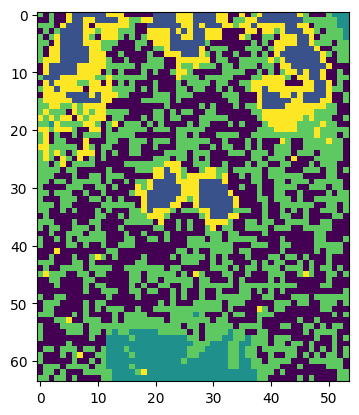

In [14]:
kmeans_T = KMEANS(transformACP(data_T), 5)
imgKmeans_T = np.reshape(kmeans_T, (54, 64)).T

plt.imshow(imgKmeans_T)

# Partie IV : Comparaison avec vérité terrain


En utilisant la vérité terrain des coupes (repectivement les matrices *ImageROI_DataSagittale*, *Image_ROI_DataTransverse*, analyser vos résultats et améliorer les.


<img src="VeriteTerrain.png" width="600" height="300">


Text(0.5, 1.0, 'Partition kmeans')

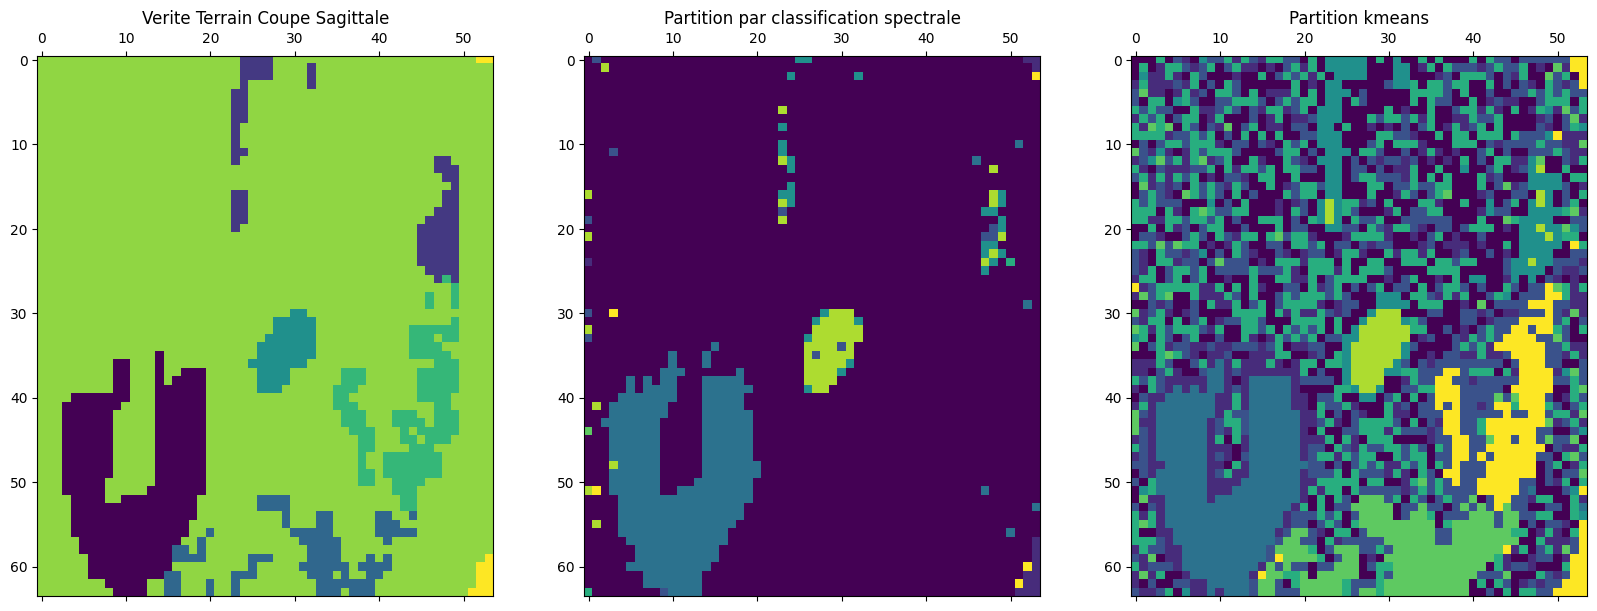

In [16]:
dataROISagit= scipy.io.loadmat('ImageROI_DataSagittale.mat') 
dataROI_S = pd.DataFrame(dataROISagit['Image_ROI_S'])


# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_S)
axs[0].set_title('Verite Terrain Coupe Sagittale')
axs[1].matshow(ImSagittaleSC.T)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(imgKmeans_S) # à modifier par Image issue du Kmeans
axs[2].set_title('Partition kmeans')


Text(0.5, 1.0, 'Partition kmeans')

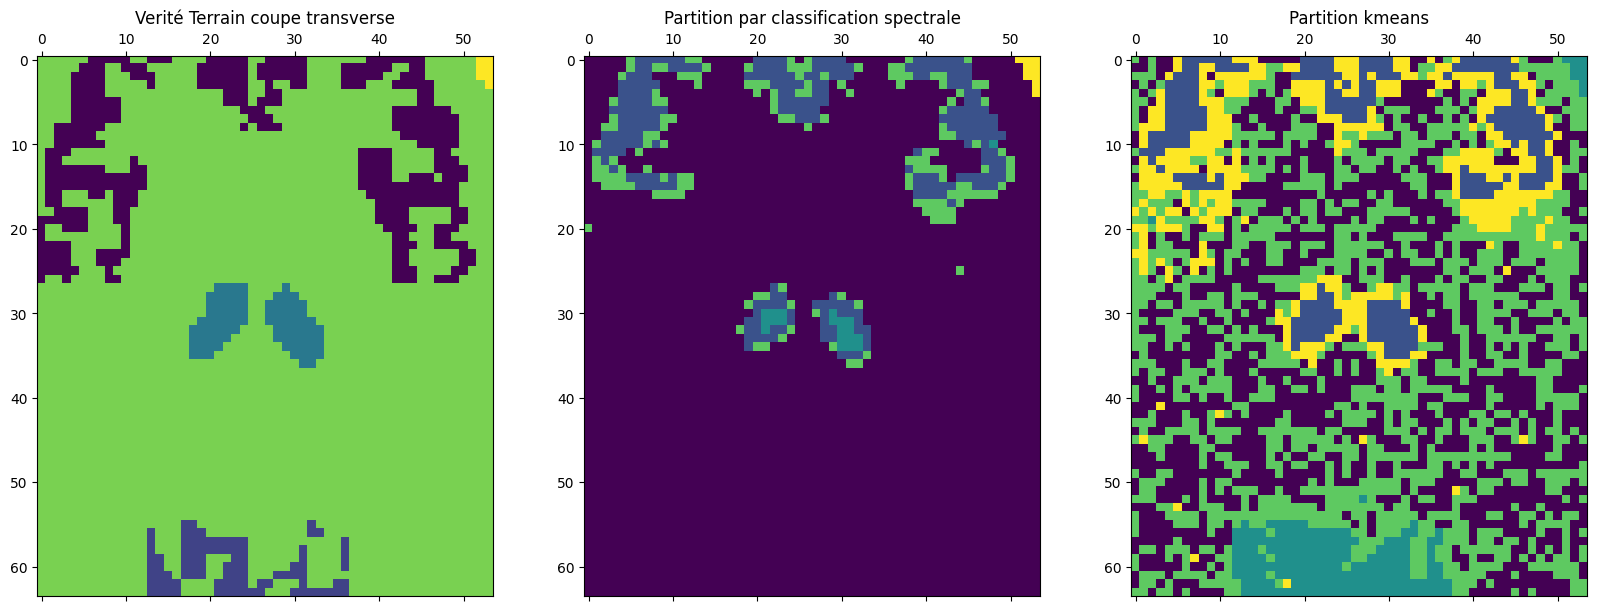

In [15]:
dataROITrans= scipy.io.loadmat('ImageROI_DataTransverse.mat') 
dataROI_T = pd.DataFrame(dataROITrans['Image_ROI_T'])


# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
axs[0].matshow(dataROI_T)
axs[0].set_title('Verité Terrain coupe transverse')
axs[1].matshow(ImTransverseSC.T)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(imgKmeans_T) # à modifier par Image issue du Kmeans
axs[2].set_title('Partition kmeans')

## Calcul de mesures de précision et rappel 

**Précision :** évalue l'exactitude des prédictions positives
$$Precision=\frac{TP}{TP+FP}$$
**Rappel :** évalue le taux d'observations positives ayant été correctement détectées par le classifieur
$$Rappel = \frac{TP}{TP+FN}$$

<img src="PrecisionRappel.png" width="300" height="300">


**Indice de Fowlkes-Mallows index (FMI)** mesure la similarité entre deux partitionnements. C'est une moyenne géométrique entre la précision et le rappel :

$$FMI = \frac{TP}{\sqrt{TP + FP) * (TP + FN)}}$$

In [18]:
from sklearn.metrics.cluster import fowlkes_mallows_score

# Coupe Sagittale : Vectorisation de l'image de verité terrain
VecdataROI_S=np.ravel(dataROI_S)
  
# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
resultatSC=fowlkes_mallows_score(VecdataROI_S,PartitionSC_S)
print('Resultat Sagittale - Classification Spectrale :',resultatSC)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans SANS ACP
resultatKmeans=fowlkes_mallows_score(VecdataROI_S, kmeansSansACP_S)
print('Resultat Sagittale - Kmeans :',resultatKmeans)

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans 
resultatKmeans=fowlkes_mallows_score(VecdataROI_S, kmeans_S)
print('Resultat Sagittale - Kmeans avec ACP :',resultatKmeans)


Resultat Sagittale - Classification Spectrale : 0.691992377405711
Resultat Sagittale - Kmeans : 0.3265676734143221
Resultat Sagittale - Kmeans avec ACP : 0.32200711902118145


In [19]:

# Coupe Transverse : Vectorisation de l'image de verité terrain
VecdataROI_T=np.ravel(dataROI_T)

# Mesure d'évalution pour la coupe transverse  pour la classification spectrale
resultatSC=fowlkes_mallows_score(VecdataROI_T,PartitionSC_T)
print('Resultat Transverse - Classification Spectrale :',resultatSC)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans SANS ACP
resultatKmeans=fowlkes_mallows_score(VecdataROI_T, kmeansSansACP_T)
print('Resultat Sagittale - Kmeans :',resultatKmeans)

# Mesure d'évalution pour la coupe transverse  pour le Kmeans 
resultatKmeans=fowlkes_mallows_score(VecdataROI_T, kmeans_T)
print('Resultat Sagittale - Kmeans avec ACP :',resultatKmeans)

Resultat Transverse - Classification Spectrale : 0.7269464965062572
Resultat Sagittale - Kmeans : 0.3458836956518501
Resultat Sagittale - Kmeans avec ACP : 0.46136375336471325


# Partie V : votre analyse

A partir des méthodes que vous avez implémentées, sur le notebook 
- Réaliser une analyse sur les résultats des méthodes de classification non supervisée : classification spectrale, kmeans et ACP+kmeans
- Tester pour différentes valeurs de paramètres $\sigma$ et de classes 

Rédiger sur un cartouche l'analyse effectuée et vos conclusions.

Le notebook sera à rendre sur moodle. 

## Votre analyse 


Rédiger votre analyse et vos conclusions.







La classification spectrale se révèle bien plus efficace que le kmeans, autant pour les coupes que pour l'exemple jouet. L'exemple jouet notament est un exemple typique de dataset sur lequel le kmeans ne fonctionne que très peu : ce modèle est incapable de séparer deux nuages de points qui ne soient pas séparés par une droite.  

On remarque que l'ACP ne rend pas toujours les résultats du Kmeans meilleurs : pour la coupe transversale, il y a une petite amélioration, pour la sagittale la classification est carrément moins bonne avec ACP. 